In [9]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Clustering

In [10]:
from sklearn.datasets import load_iris

In [11]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

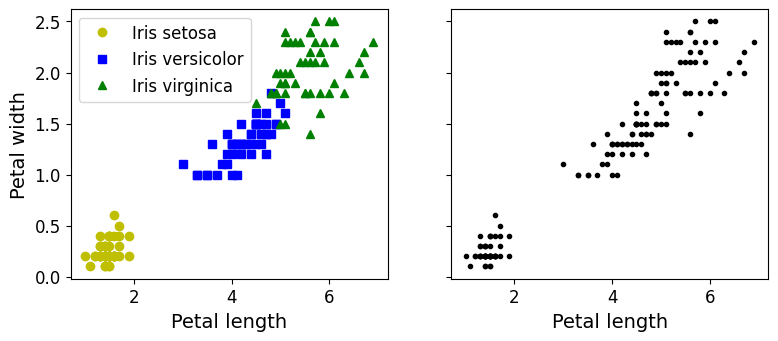

In [12]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [13]:
from sklearn.mixture import GaussianMixture

In [14]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping (as is done in the book, for simplicity), we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [15]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

C:\Users\mreis\AppData\Local\Temp\ipykernel_8288\1686138522.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(y_pred[y==class_id])


{1: 0, 2: 1, 0: 2}

In [16]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

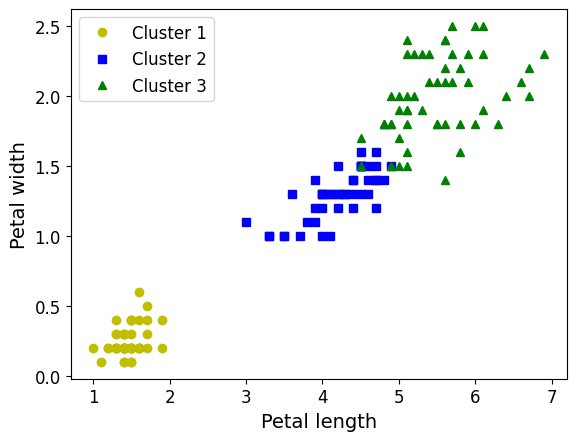

In [17]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [18]:
np.sum(y_pred==y)

145

In [19]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

#### K-Means

Let's start by generating some blobs:

In [20]:
from sklearn.datasets import make_blobs

In [21]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [22]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [23]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

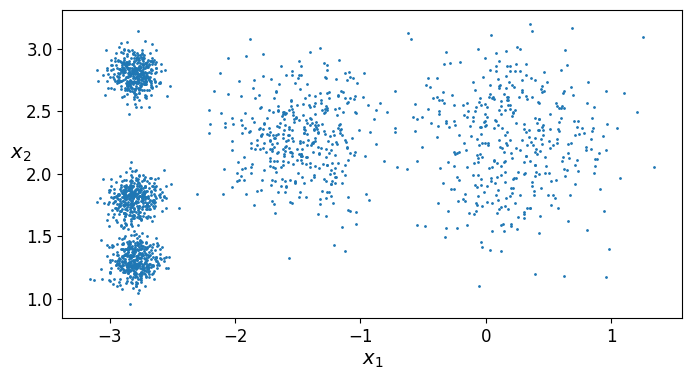

In [24]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

plt.show()

**Fit and predict**

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [25]:
from sklearn.cluster import KMeans

In [26]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [28]:
y_pred is kmeans.labels_

True

And the following 5 *centroids* (i.e., cluster centers) were estimated:

In [29]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to:

In [30]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

Of course, we can predict the labels of new instances:

In [31]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a *Voronoi diagram*:

In [32]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

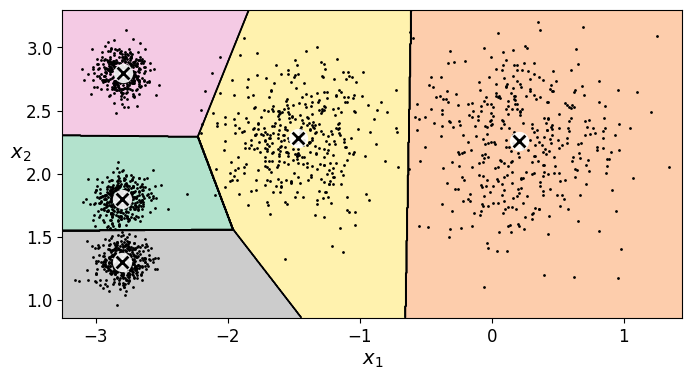

In [33]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering vs Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called *hard clustering*, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [34]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [35]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

##### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:

* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1` and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [36]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

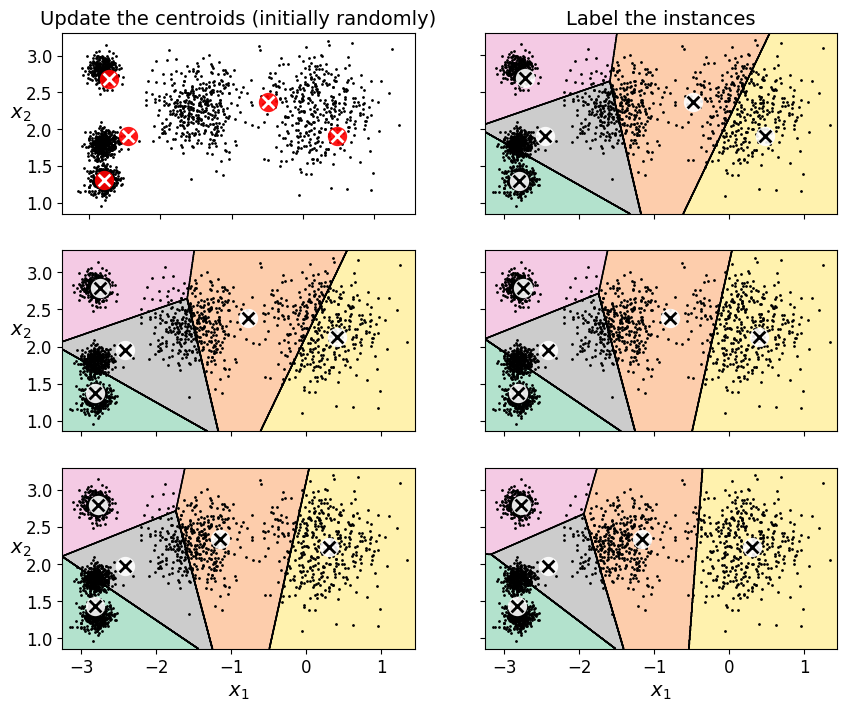

In [37]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [38]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


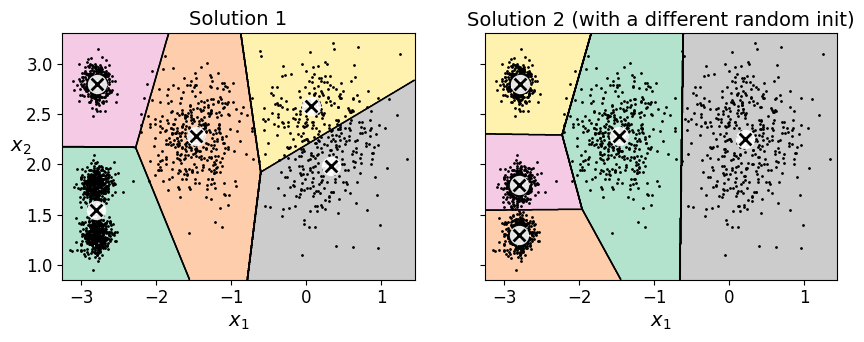

In [39]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

##### Centroid initialization methods

In [40]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

In [41]:
kmeans.score(X)

-211.5985372581684

##### Mini-Batch K-Means

In [42]:
from sklearn.cluster import MiniBatchKMeans

In [43]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [44]:
minibatch_kmeans.inertia_

211.65239850433204

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [45]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

c:\Python39\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

In [47]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [48]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [49]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [50]:
np.random.seed(42)

In [51]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will 

In [52]:
best_kmeans.score(X)

-211.62571878891143

Mini-batch K-Means is much faster than regular K-Means:

In [53]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

37.1 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will 

67 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as k increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [55]:
from timeit import timeit

In [56]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

1/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

2/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

3/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

4/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

5/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

6/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

7/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

8/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

9/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

10/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

11/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

12/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

13/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

14/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

15/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

16/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

17/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

18/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

19/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

20/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

21/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

22/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

23/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

24/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

25/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

26/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

27/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

28/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

29/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

30/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

31/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

32/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

33/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

34/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

35/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

36/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

37/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

38/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

39/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

40/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

41/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

42/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

43/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

44/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

45/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

46/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

47/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

48/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

49/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

50/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

51/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

52/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

53/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

54/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

55/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

56/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

57/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

58/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

59/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

60/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

61/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

62/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

63/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

64/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

65/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

66/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

67/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

68/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

69/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

70/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

71/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

72/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

73/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

74/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

75/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

76/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

77/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

78/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

79/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

80/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

81/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

82/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

83/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

84/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

85/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

86/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

87/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

88/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

89/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

90/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

91/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

92/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

93/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

94/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

95/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

96/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

97/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

98/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

99/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

100/100

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

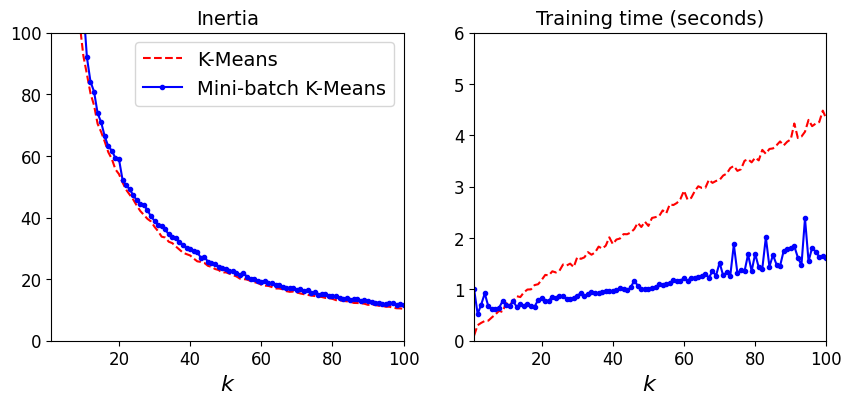

In [57]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

##### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


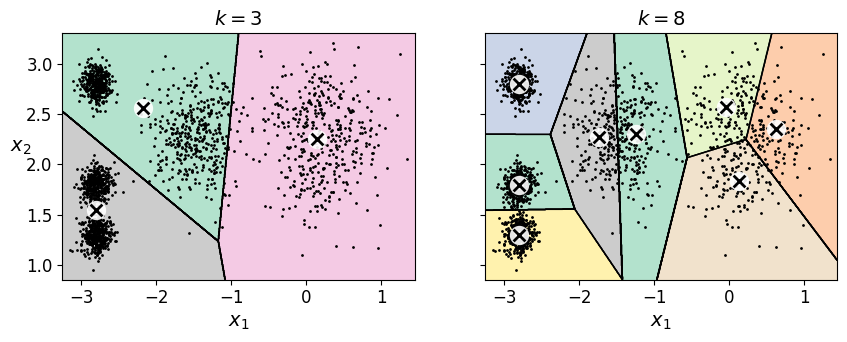

In [58]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")

plt.show()

Ouch, these two models don't look great. What about their inertias?

In [59]:
kmeans_k3.inertia_

653.2167190021553

In [60]:
kmeans_k8.inertia_

119.1198341610288

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [61]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

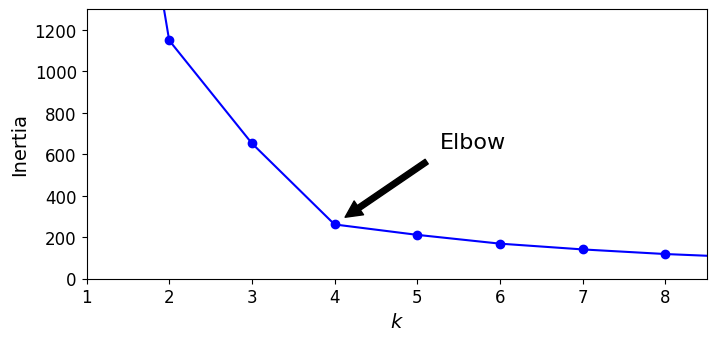

In [62]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

plt.show()

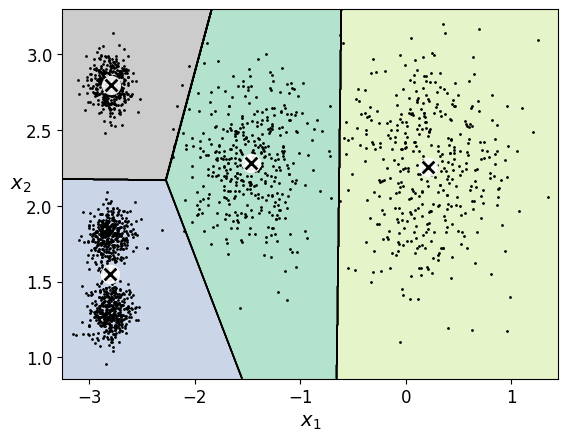

In [63]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

In [64]:
from sklearn.metrics import silhouette_score

In [65]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [66]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

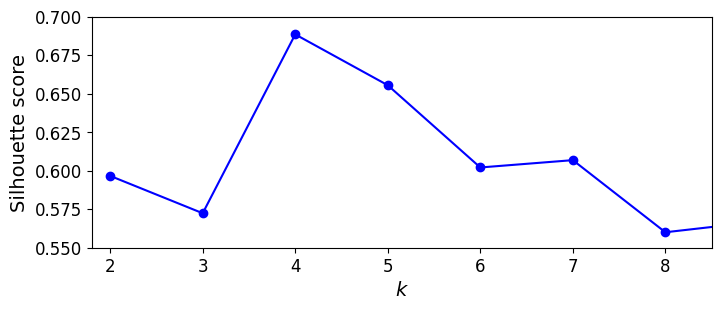

In [67]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a *silhouette diagram*:

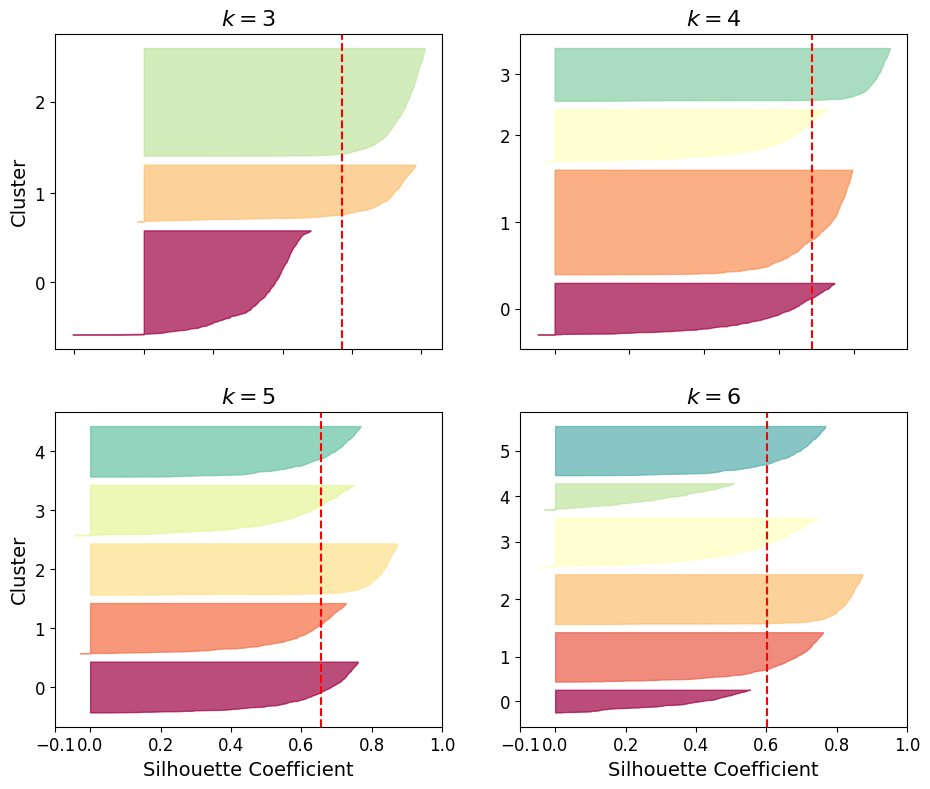

In [68]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

#### Limits of K-Means